In [2]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import pandas as pd
import os
import re
import io
import requests
import matplotlib.pyplot as plt
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

In [3]:
# torch関連ライブラリのインポート
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
from sklearn.metrics import roc_auc_score
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torch.nn import functional as F
from torch import nn

In [4]:
import lightgbm as lgb
import xgboost as xgb
import catboost as cat

#from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from torchmetrics.functional import auc

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

In [6]:
# デバイスの割り当て
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [7]:
# PyTorch乱数固定用
def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

In [8]:
df = pd.read_csv('../rcsed.csv')

In [9]:
gasmet = pd.read_csv('../rcsed_gasmet.csv')

In [10]:
id_col = ['objid','specobjid']
z_col = [  'exp_tau','exp_met','z', 'e_bv', 'ssp_age', 'ssp_met', 'specclass']

band_col = [
    'corrmag_fuv', 'corrmag_nuv', 'corrmag_u', 'corrmag_g', 'corrmag_r', 'corrmag_i', 
    'corrmag_z', 'corrmag_y', 'corrmag_j', 'corrmag_h', 'corrmag_k'
]

kcorr_col = [
     'kcorr_fuv','kcorr_nuv','kcorr_u','kcorr_g','kcorr_r','kcorr_i',
     'kcorr_z','kcorr_y','kcorr_j','kcorr_h','kcorr_k',
]

In [11]:
col = id_col + z_col + band_col + kcorr_col

In [12]:
data = df[col].dropna()

In [13]:
data[band_col].head()

,corrmag_fuv,corrmag_nuv,corrmag_u,corrmag_g,corrmag_r,corrmag_i,corrmag_z,corrmag_y,corrmag_j,corrmag_h,corrmag_k
18,20.430805,20.963827,19.483593,18.175556,17.582560,17.170374,16.867794,16.277828,16.224766,15.796741,15.897239
20,20.316390,19.689003,18.913360,17.633633,17.118832,16.801023,16.559082,16.183378,16.157516,16.061178,15.977037
25,20.786072,19.694458,18.216558,16.744936,15.942631,15.533159,15.280964,14.804124,14.598612,14.280346,14.365913
28,20.476007,19.936340,18.627714,17.455538,16.852865,16.501130,16.458048,15.947557,15.661368,15.418820,15.581812
29,19.992838,19.668417,18.950533,17.954803,17.538660,17.193727,17.054646,16.804903,16.682253,16.268763,16.288889


In [21]:
Encoder = torch.nn.Sequential(
    
    nn.Linear(11,512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    
    nn.Linear(512,512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),

    nn.Linear(512,256),
    nn.BatchNorm1d(256),
    nn.ReLU(inplace=True),
    
)
Mean = torch.nn.Sequential(
    nn.Linear(256,2),
)
Log_var = torch.nn.Sequential(
    nn.Linear(256,2),
)
Decoder = torch.nn.Sequential(
    
    nn.Linear(2,256),
    nn.BatchNorm1d(256),
    nn.ReLU(inplace=True),    
    
    nn.Linear(256,512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    
    nn.Linear(512,512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.2),
    
    nn.Linear(512,11),
    nn.Sigmoid()
)

class VAE(torch.nn.Module):
    def __init__(self, Encoder, Decoder, Mean, Log_var):
        super().__init__()
        self.encoder = Encoder
    
        self.mean = Mean 
        self.log_var = Log_var 
        
        self.decoder = Decoder
    def forward(self, x):
        x = self.encoder(x)
        
        #平均 μ
        mean = self.mean(x) 
       
        # log σ^2
        log_var = self.log_var(x)
        
        # 潜在変数を求める
        # 標準正規乱数を振る
        eps = torch.randn_like(torch.exp(log_var),device=device)
        
        # 潜在変数の計算 μ + σ・ε
        z = mean + torch.exp(log_var / 2) * eps
        
        x = self.decoder(z)
        return x, mean, log_var, z 

In [32]:
# 損失関数はなにがいい
def loss_function(inputs, outputs, maen, log_var):
    reconstruction_loss = torch.sum(inputs * torch.log(outputs + np.spacing(1)) + (1 - inputs) * torch.log(1 - outputs + np.spacing(1))) # 再構成誤差計算
    kl_loss = 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp()) # KLダイバージェンス計算
    vae_loss = - ( reconstruction_loss + kl_loss )
    return vae_loss, reconstruction_loss, kl_loss

In [33]:
## x_train = np.array( data[band_col] )
mm = MinMaxScaler()
x_train = data[band_col]
x_train = mm.fit_transform(x_train)
y_train = np.zeros([x_train.shape[0]])
# ミニバッチのサイズ指定
batch_size = 32

train_data = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
trainloader = DataLoader(train_data, batch_size = batch_size, shuffle=True)

In [34]:
model = VAE(Encoder, Decoder, Mean, Log_var)
model.train()
learning_rate = 0.0001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0)
history = np.zeros((0,4))

In [35]:
# PyTorch乱数固定用
def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

In [36]:
%%time
# 乱数初期化
torch_seed()
num_epochs = 100
base_epochs = len(history)
for epoch in range(base_epochs, num_epochs+base_epochs):
    train_loss = 0
    train_recon_loss = 0
    train_kl_loss = 0
    for i, (inputs, _) in enumerate(trainloader):
        outputs, mean, log_var, z = model(inputs.float())
        
        # 損失関数の計算
        loss, recon_loss, kl_loss = loss_function(inputs, outputs, mean, log_var)

        # パラメータの更新
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_recon_loss += recon_loss.item()
        train_kl_loss += kl_loss.item()
        
    avg_train_loss = train_loss / i
    avg_train_recon_loss = train_recon_loss / i
    avg_train_kl_loss = train_kl_loss / i
    
    item = np.array([epoch+1, avg_train_loss , avg_train_recon_loss, avg_train_kl_loss])
    history = np.vstack((history, item))
    
    print('Epoch:',round((epoch+1)/(num_epochs+base_epochs),3),
          'loss:',avg_train_loss,
          'reconstruct loss:',avg_train_recon_loss,
          'KL loss:',avg_train_kl_loss)

Epoch: 0.01 loss: 242.6706219266534 reconstruct loss: -242.61594019564956 KL loss: -0.05468173100386804
Epoch: 0.02 loss: 241.37869582387398 reconstruct loss: -241.34013203833612 KL loss: -0.038563785537824795
Epoch: 0.03 loss: 241.08917841770014 reconstruct loss: -241.05754892590278 KL loss: -0.03162949179735897
Epoch: 0.04 loss: 240.93749563251149 reconstruct loss: -240.9098988322023 KL loss: -0.027596800309200746
Epoch: 0.05 loss: 240.8462776003406 reconstruct loss: -240.82258737889882 KL loss: -0.023690221441836006
Epoch: 0.06 loss: 240.78836526058294 reconstruct loss: -240.767252926042 KL loss: -0.02111233454092411
Epoch: 0.07 loss: 240.75396393440363 reconstruct loss: -240.73467718730785 KL loss: -0.019286747095780182
Epoch: 0.08 loss: 240.73047785534087 reconstruct loss: -240.71292144123802 KL loss: -0.017556414102851334
Epoch: 0.09 loss: 240.71363478818608 reconstruct loss: -240.69752144322732 KL loss: -0.016113344958778156
Epoch: 0.1 loss: 240.6985480028229 reconstruct loss: -

Epoch: 0.79 loss: 240.65247846570634 reconstruct loss: -240.65016248794967 KL loss: -0.0023159777566706392
Epoch: 0.8 loss: 240.6509311475809 reconstruct loss: -240.64853539337443 KL loss: -0.002395754206483647
Epoch: 0.81 loss: 240.65131247275795 reconstruct loss: -240.6490037829635 KL loss: -0.0023086897944663205
Epoch: 0.82 loss: 240.65143518690613 reconstruct loss: -240.64918044256692 KL loss: -0.002254744339208145
Epoch: 0.83 loss: 240.6519757563173 reconstruct loss: -240.6497643882165 KL loss: -0.0022113681007913276
Epoch: 0.84 loss: 240.65151454847808 reconstruct loss: -240.64938511437003 KL loss: -0.002129434108060632
Epoch: 0.85 loss: 240.65148511003213 reconstruct loss: -240.64933092487433 KL loss: -0.0021541851577954103
Epoch: 0.86 loss: 240.65110853248956 reconstruct loss: -240.64889193517564 KL loss: -0.0022165973139348003
Epoch: 0.87 loss: 240.6519836833309 reconstruct loss: -240.6498772670339 KL loss: -0.0021064162969925983
Epoch: 0.88 loss: 240.65120126279308 reconstruc

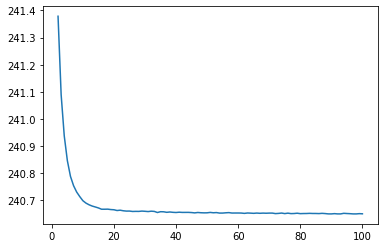

In [37]:
plt.plot(history[1:,0], history[1:,1])

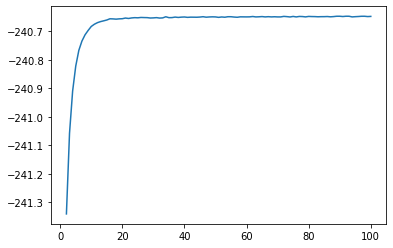

In [38]:
plt.plot(history[1:,0], history[1:,2])

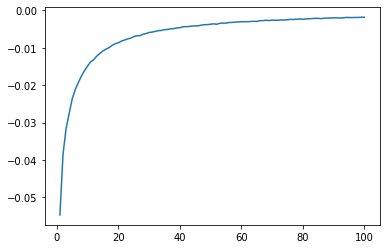

In [40]:
plt.plot(history[-1000:,0], history[-1000:,3])

In [47]:
x = torch.from_numpy(x_train)
x = model.encoder(x.float())
mean = model.mean(x)
log_var = model.log_var(x)
latent = mean
eps = torch.randn(mean.shape,device=device)

# 潜在変数の計算 μ + σ・ε
z = mean + torch.exp(log_var * 0.5) * eps

model.decoder(z)[:5]

tensor([[0.5266, 0.4993, 0.3405, 0.4352, 0.4216, 0.4268, 0.4741, 0.4711, 0.4440,
         0.4728, 0.4316],
        [0.5326, 0.5050, 0.3451, 0.4399, 0.4259, 0.4309, 0.4789, 0.4755, 0.4488,
         0.4777, 0.4363],
        [0.5328, 0.5084, 0.3451, 0.4432, 0.4289, 0.4342, 0.4823, 0.4781, 0.4518,
         0.4800, 0.4374],
        [0.5330, 0.5055, 0.3439, 0.4409, 0.4263, 0.4323, 0.4823, 0.4786, 0.4522,
         0.4809, 0.4382],
        [0.5348, 0.5075, 0.3487, 0.4412, 0.4271, 0.4320, 0.4791, 0.4763, 0.4511,
         0.4779, 0.4371]], grad_fn=<SliceBackward0>)

In [48]:
torch.from_numpy(x_train)[:5] - model.decoder(z)[:5]

tensor([[-0.0064,  0.0946,  0.0345,  0.0419,  0.0422,  0.0374,  0.0333,  0.0208,
          0.0225,  0.0122,  0.0083],
        [-0.0276, -0.0252,  0.0040,  0.0013,  0.0109,  0.0118,  0.0061,  0.0127,
          0.0195,  0.0314,  0.0170],
        [ 0.0146, -0.0319, -0.0521, -0.0767, -0.0868, -0.0923, -0.1064, -0.1039,
         -0.1110, -0.1121, -0.1095],
        [-0.0125, -0.0041, -0.0212, -0.0183, -0.0147, -0.0163, -0.0075, -0.0117,
         -0.0264, -0.0234, -0.0180],
        [-0.0509, -0.0232, -0.0049,  0.0228,  0.0376,  0.0373,  0.0468,  0.0611,
          0.0561,  0.0472,  0.0355]], dtype=torch.float64,
       grad_fn=<SubBackward0>)

In [49]:
latent1 = z[:,0]
latent2 = z[:,1]

In [50]:
latent1 = latent1.detach().numpy()
latent2 = latent2.detach().numpy()

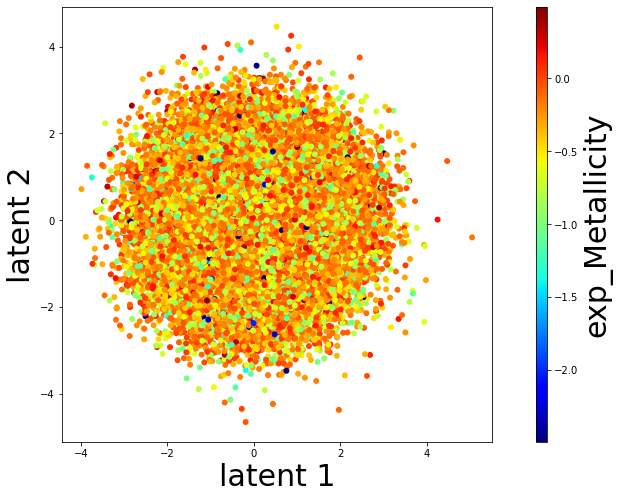

In [51]:
plt.figure(figsize=(10,8))
plt.scatter(latent1, latent2, c = data['exp_met'], cmap=plt.cm.jet, edgecolor='none',)
plt.colorbar(aspect=40, pad=0.08, orientation='vertical', label = 'exp_Metallicity').set_label('exp_Metallicity', fontsize=30)
plt.savefig('VAE_exp_met.png')
plt.xlabel('latent 1', fontsize = 30)
plt.ylabel('latent 2', fontsize = 30)
plt.show()

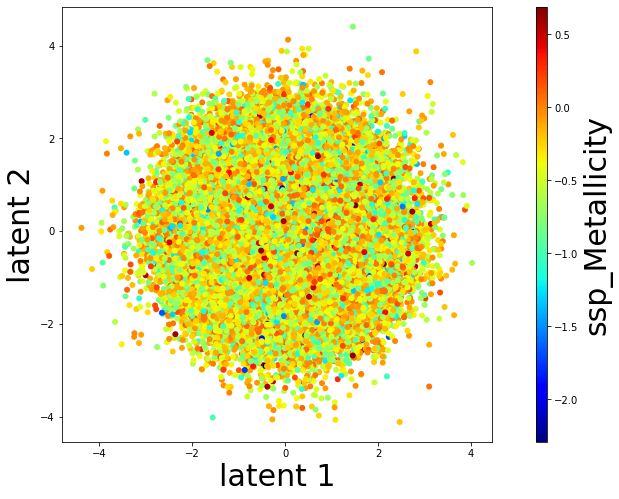

In [46]:
plt.figure(figsize=(10,8))
plt.scatter(latent1, latent2, c = data['ssp_met'], cmap=plt.cm.jet, edgecolor='none',)
plt.colorbar(aspect=40, pad=0.08, orientation='vertical', label = 'ssp_Metallicity').set_label('ssp_Metallicity', fontsize=30)
plt.savefig('VAE_ssp_met.png')
plt.xlabel('latent 1', fontsize = 30)
plt.ylabel('latent 2', fontsize = 30)
plt.show()

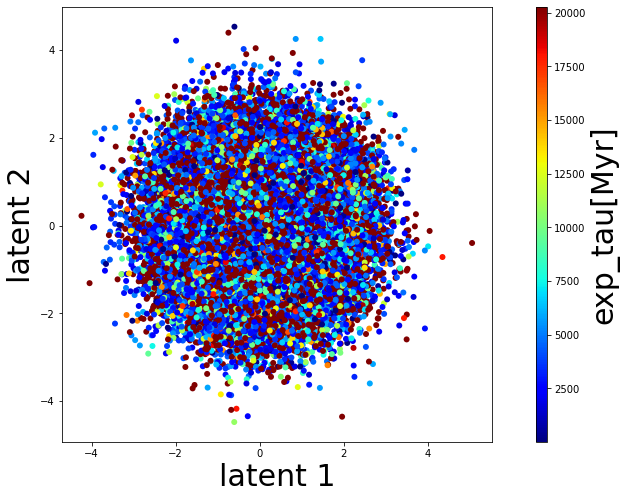

In [128]:
plt.figure(figsize=(10,8))
plt.scatter(latent1, latent2, c = data['exp_tau'], cmap=plt.cm.jet, edgecolor='none')
plt.colorbar(aspect=40, pad=0.08, orientation='vertical').set_label('exp_tau[Myr]', fontsize=30)
plt.savefig('VAE_tau_age.png')
plt.xlabel('latent 1', fontsize = 30)
plt.ylabel('latent 2', fontsize = 30)
plt.show()

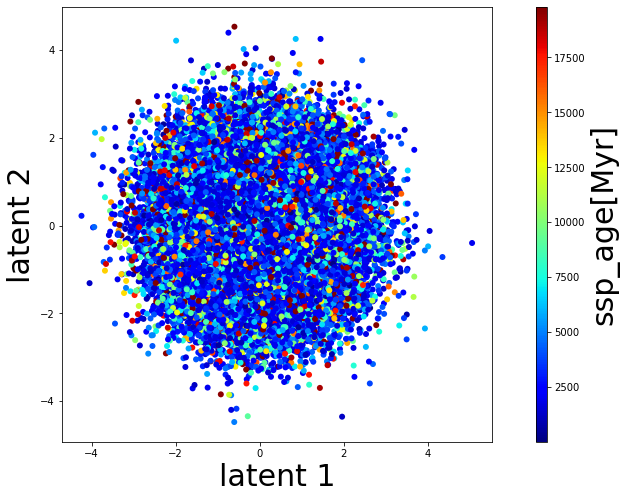

In [129]:
plt.figure(figsize=(10,8))
plt.scatter(latent1, latent2, c = data['ssp_age'], cmap=plt.cm.jet, edgecolor='none')
plt.colorbar(aspect=40, pad=0.08, orientation='vertical').set_label('ssp_age[Myr]', fontsize=30)
plt.savefig('VAE_ssp_age.png')
plt.xlabel('latent 1', fontsize = 30)
plt.ylabel('latent 2', fontsize = 30)
plt.show()

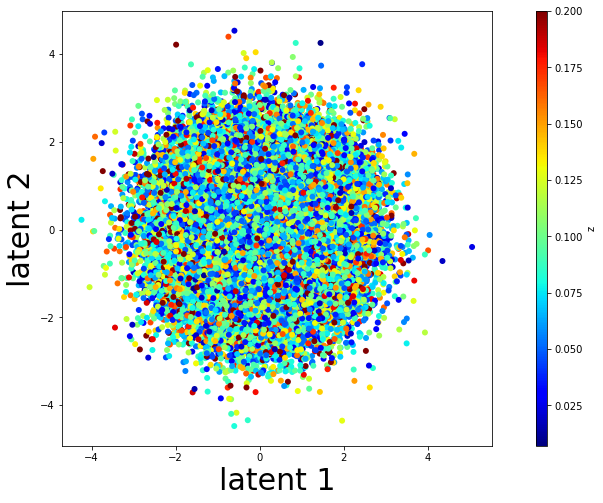

In [130]:
plt.figure(figsize=(10,8))
plt.scatter(latent1, latent2, c = data['z'].values, cmap=plt.cm.jet, edgecolor='none', vmax=0.2)
plt.colorbar(aspect=40, pad=0.08, orientation='vertical', label = 'z')
plt.savefig('VAE_z.png')
plt.xlabel('latent 1', fontsize = 30)
plt.ylabel('latent 2', fontsize = 30)
plt.show()

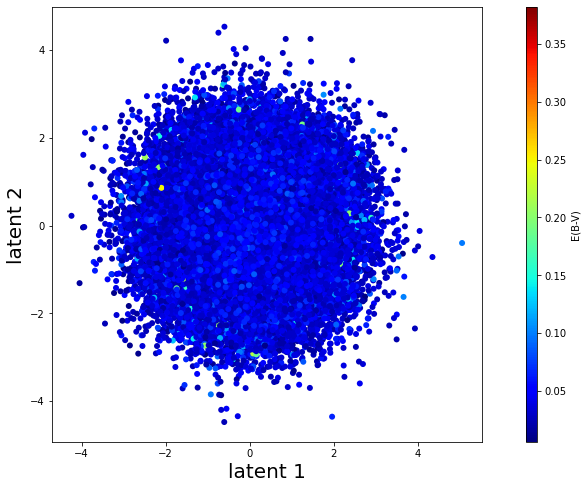

In [131]:
plt.figure(figsize=(10,8))
plt.scatter(latent1, latent2, c = data['e_bv'].values, cmap=plt.cm.jet, edgecolor='none')
plt.colorbar(aspect=40, pad=0.08, orientation='vertical', label = 'E(B-V)')
plt.savefig('E(B-V).png')
plt.xlabel('latent 1', fontsize = 20)
plt.ylabel('latent 2', fontsize = 20)
plt.show()

In [31]:
data['specclass'].value_counts()

2    90635
Name: specclass, dtype: int64